# **SafeRoads: AI-Enabled Accident Detection**

**Prediction of Yolo Model built from scratch.**

**By: Puyush Gupta**

In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape, Dropout, Add

classes=["bike","bike_bike_accident","bike_object_accident","bike_person_accident","car",
    "car_bike_accident","car_car_accident","car_object_accident","car_person_accident","person"]

# no of boundary for each grid
B = 2 
# number of classes defined in images
N_CLASSES = len(classes)
# height, weight of images
H, W = 512, 512
# number of grids in a row/column
SPLIT_SIZE = H//32
# number of epochs
N_EPOCHS=70
# Batch size
BATCH_SIZE=64

In [7]:
def residual_block(X,filters):
    # Retrieve Filters
    F1, F2, F3 = filters
    # Saving the input value.we need this later to add to the output. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.1)(X)

    # Second component of main path 
    X = Conv2D(filters = F2, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.1)(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization()(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = LeakyReLU(alpha=0.1)(X)
    return X

# The function constructs the model using a pre-trained ResNet50 base model with weights initialized from the ImageNet dataset. 
# It then adds custom layers on top of the base model to adapt it for object detection.
def build_custom_model(H, W, N_CLASSES, B, NUM_FILTERS, SPLIT_SIZE, OUTPUT_DIM):
    # Load pre-trained ResNet50 model without the top classification layers
    base_model = ResNet50(
        weights='imagenet',
        input_shape=(H, W, 3),  # Input shape of the images (height, width, channels)
        include_top=False  # Exclude the top classification layers
    )

    # Freeze the base model's layers to prevent them from being trained
    base_model.trainable = False
    x = base_model.output

    # Add a convolutional layer with 512 filters, followed by batch normalization and LeakyReLU activation
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Add a custom residual block (function residual_block needs to be defined separately)
    x = residual_block(x, [64, 64, 128])  

    # Add another convolutional layer with 1024 filters, followed by batch normalization and LeakyReLU activation
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Add another custom residual block
    x = residual_block(x, [128, 128, 256])  
    x = Dropout(0.35)(x)
    x = Flatten()(x)  # Flatten the output for dense layers

    # Add a dense layer with NUM_FILTERS units, followed by batch normalization, LeakyReLU activation, and dropout
    x = Dense(NUM_FILTERS, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.35)(x)

    # Add a dense layer with output dimension SPLIT_SIZE * SPLIT_SIZE * OUTPUT_DIM
    # The activation function is sigmoid
    x = Dense(SPLIT_SIZE * SPLIT_SIZE * OUTPUT_DIM, activation='sigmoid')(x)
    # Reshape the output to (SPLIT_SIZE, SPLIT_SIZE, OUTPUT_DIM)
    x = Reshape((SPLIT_SIZE, SPLIT_SIZE, OUTPUT_DIM))(x)

    # Define the model with base_model's input as input and x as output
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

# Number of filters in convolutional layer
NUM_FILTERS = 512
# Calculate OUTPUT_DIM based on the number of classes and bounding boxes per grid
OUTPUT_DIM = N_CLASSES + 5 * B
# Build the custom model with the specified parameters
model = build_custom_model(H, W, N_CLASSES, B, NUM_FILTERS, SPLIT_SIZE, OUTPUT_DIM)

In [8]:
# Function calculates the Intersection over Union (IoU) between two sets of bounding boxes. 
# It first transforms the boxes into the format (left, up, right, down), then computes the coordinates of the intersection area, 
# as well as the areas of the individual boxes and their union. 
def compute_iou(boxes1, boxes2):
    # Transform the boxes to (left, up, right, down) format
    boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                         boxes1[..., 1] - boxes1[..., 3] / 2.0,
                         boxes1[..., 0] + boxes1[..., 2] / 2.0,
                         boxes1[..., 1] + boxes1[..., 3] / 2.0],
                        axis=-1)

    boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                         boxes2[..., 1] - boxes2[..., 3] / 2.0,
                         boxes2[..., 0] + boxes2[..., 2] / 2.0,
                         boxes2[..., 1] + boxes2[..., 3] / 2.0],
                        axis=-1)
    
    # Compute the coordinates of the top-left (lu) and bottom-right (rd) corners of the intersection
    lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
    rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])

    # Compute the intersection area
    intersection = tf.maximum(0.0, rd - lu)
    inter_square = intersection[..., 0] * intersection[..., 1]

    # Compute the areas of each bounding box
    square1 = boxes1[..., 2] * boxes1[..., 3]
    square2 = boxes2[..., 2] * boxes2[..., 3]

    # Compute the union area
    union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)
    
    # Compute the IoU (Intersection over Union)
    iou = tf.clip_by_value(inter_square / union_square, 0.0, 1.0)
    
    return iou


def difference(x, y):
    # Compute the sum of squared differences between x and y
    return tf.reduce_sum(tf.square(y - x))

def yolo_loss(y_true, y_pred):
    target = y_true[...,0]

    ###################### Object Loss ######################

    # Extract predicted and target values for the objects
    y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:]==1))
    y_target_extract = tf.gather_nd(y_true, tf.where(target[:]==1))

    # Compute rescaling values
    rescaler = tf.where(target[:]==1) * SPLIT_SIZE
    upscaler_1 = tf.concat([rescaler[:,1:], tf.zeros([len(rescaler),2], dtype=tf.int64)], axis=-1)

    # Upscale target and prediction coordinates
    target_upscaler_2 = tf.repeat([[float(SPLIT_SIZE), float(SPLIT_SIZE), H, W]],
                                  repeats=[len(rescaler)], axis=0) * tf.cast(y_target_extract[...,1:5], dtype=tf.float32)
    pred_1_upscaler_2 = tf.repeat([[float(SPLIT_SIZE), float(SPLIT_SIZE), H, W]],
                                   repeats=[len(rescaler)], axis=0) * tf.cast(y_pred_extract[...,1:5], dtype=tf.float32)
    pred_2_upscaler_2 = tf.repeat([[float(SPLIT_SIZE), float(SPLIT_SIZE), H, W]],
                                   repeats=[len(rescaler)], axis=0) * tf.cast(y_pred_extract[...,6:10], dtype=tf.float32)

    # Compute original coordinates
    target_orig = tf.cast(upscaler_1, dtype=tf.float32) + target_upscaler_2
    pred_1_orig = tf.cast(upscaler_1, dtype=tf.float32) + pred_1_upscaler_2
    pred_2_orig = tf.cast(upscaler_1, dtype=tf.float32) + pred_2_upscaler_2

    # Compute mask for object comparison
    mask = tf.cast(tf.math.greater(compute_iou(target_orig, pred_2_orig),
                                    compute_iou(target_orig, pred_1_orig)), dtype=tf.int32)

    # Extract object predictions based on mask
    y_pred_joined = tf.transpose(tf.concat([tf.expand_dims(y_pred_extract[...,0], axis=0),
                                             tf.expand_dims(y_pred_extract[...,5], axis=0)], axis=0))
    obj_pred = tf.gather_nd(y_pred_joined, tf.stack([tf.range(len(rescaler)), mask], axis=-1))

    # Compute object loss
    object_loss = difference(tf.cast(obj_pred, dtype=tf.float32), tf.cast(tf.ones([len(rescaler)]), dtype=tf.float32))

    ####################### For No object #######################

    # Extract predicted values for non-objects
    y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==0))
    y_target_extract = tf.zeros(len(y_pred_extract))

    # Compute no object loss
    no_object_loss_1 = difference(tf.cast(y_pred_extract[...,0], dtype=tf.float32),
                                   tf.cast(y_target_extract, dtype=tf.float32))
    no_object_loss_2 = difference(tf.cast(y_pred_extract[...,5], dtype=tf.float32),
                                   tf.cast(y_target_extract, dtype=tf.float32))
    no_object_loss = no_object_loss_1 + no_object_loss_2

    ######################## For Object class loss #######################

    # Extract predicted class values for objects
    y_pred_extract = tf.gather_nd(y_pred[...,10:], tf.where(target[:]==1))
    class_extract = tf.gather_nd(y_true[...,5:], tf.where(target[:]==1))

    # Compute object class loss
    class_loss = difference(tf.cast(y_pred_extract, dtype=tf.float32),
                            tf.cast(class_extract, dtype=tf.float32))

    ######################### For object bounding box loss ####################

    # Extract predicted bounding box values for objects
    y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==1))
    centre_joined = tf.stack([y_pred_extract[...,1:3], y_pred_extract[...,6:8]], axis=1)
    centre_pred = tf.gather_nd(centre_joined, tf.stack([tf.range(len(rescaler)), mask], axis=-1))
    centre_target = tf.gather_nd(y_true[...,1:3], tf.where(target[:]==1))

    # Compute centre loss
    centre_loss = difference(centre_pred, centre_target)

    size_joined = tf.stack([y_pred_extract[...,3:5], y_pred_extract[...,8:10]], axis=1)
    size_pred = tf.gather_nd(size_joined, tf.stack([tf.range(len(rescaler)), mask], axis=-1))
    size_target = tf.gather_nd(y_true[...,3:5], tf.where(target[:]==1))

    # Compute size loss
    size_loss = difference(tf.math.sqrt(tf.math.abs(size_pred)),
                           tf.math.sqrt(tf.math.abs(size_target)))
    box_loss = centre_loss + size_loss

    lambda_coord = 5.0
    lambda_no_obj = 0.5

    # Compute total loss
    loss = object_loss + (lambda_no_obj * no_object_loss) + tf.cast(lambda_coord * box_loss, dtype=tf.float32) + tf.cast(class_loss, dtype=tf.float32)
    
    return loss

In [9]:
model.compile(
    loss=yolo_loss,  # Custom YOLO loss function
    optimizer=Adam(1e-3)  # Adam optimizer 
)

model.load_weights("/kaggle/input/yolo-weights/Yolo_Scratch.keras")

In [37]:
def model_test(folder):
    # Initialize variables to count the number of accidents detected and total images processed
    accident_detected_count = 0
    total_images = 0

    try:
        # Loop through each file in the specified folder
        for filename in os.listdir(folder):
            # Construct the path to the current file
            test_path = os.path.join(folder, filename)
            # Read and resize the image using OpenCV
            img = cv2.resize(cv2.imread(test_path), (H, W))
            # Read and resize the image using TensorFlow
            image = tf.io.decode_jpeg(tf.io.read_file(test_path))
            image = tf.image.resize(image, [H, W])
            
            # Increment the total image count
            total_images += 1
            # Variable to track if an accident occurred in the current image
            accident_occured = False

            # Make predictions using the model
            output = model.predict(np.expand_dims(image, axis=0))
            # Set a threshold for confidence score
            THRESH = 0.5

            # Extract object positions from the output and filter based on confidence threshold
            object_positions = tf.concat(
                [tf.where(output[..., 0] >= THRESH), tf.where(output[..., 5] >= THRESH)], axis=0
            )
            selected_output = tf.gather_nd(output, object_positions)

            final_boxes = []  # List to store final bounding boxes
            final_scores = []  # List to store final confidence scores

            # Iterate through each object position
            for i, pos in enumerate(object_positions):
                for j in range(2):
                    # Check if confidence score is above the threshold
                    if selected_output[i][j * 5] > THRESH:
                        # Extract bounding box coordinates and other details
                        output_box = tf.cast(output[pos[0]][pos[1]][pos[2]][(j * 5) + 1:(j * 5) + 5],
                                             dtype=tf.float32)

                        x_centre = (tf.cast(pos[1], dtype=tf.float32) + output_box[0]) * 32
                        y_centre = (tf.cast(pos[2], dtype=tf.float32) + output_box[1]) * 32

                        x_width, y_height = tf.math.abs(W * output_box[2]), tf.math.abs(H * output_box[3])

                        x_min, y_min = int(x_centre - (x_width / 2)), int(y_centre - (y_height / 2))
                        x_max, y_max = int(x_centre + (x_width / 2)), int(y_centre + (y_height / 2))

                        if (x_min < 0): x_min = 0
                        if (y_min < 0): y_min = 0
                        if (x_max < 0): x_max = 0
                        if (y_max < 0): y_max = 0

                        class_label = str(classes[tf.argmax(selected_output[..., 10:], axis=-1)[i]])
                        final_boxes.append([x_min, y_min, x_max, y_max, class_label])
                        final_scores.append(selected_output[i][j * 5])

            # If there are final boxes, perform non-maximum suppression
            if final_boxes:
                final_boxes = np.array(final_boxes)
                object_classes = final_boxes[..., 4]
                nms_boxes = final_boxes[..., 0:4]
                # Perform non-maximum suppression
                nms_output = tf.image.non_max_suppression(
                    nms_boxes, final_scores, max_output_size=100, iou_threshold=0.1, score_threshold=float(0.4)
                )
                final_nms_boxes = []

                # Iterate through the output of non-maximum suppression
                for i in nms_output:
                    if final_boxes[i][-1] in ["bike_bike_accident", "bike_object_accident", "bike_person_accident", "car_bike_accident", "car_car_accident", "car_object_accident","car_person_accident"]:
                        # If an accident is detected, increment the count and set the flag
                        accident_detected_count += 1
                        accident_occured = True
                    # Draw bounding box and label on the image
                    cv2.rectangle(
                        img,
                        (int(final_boxes[i][0]), int(final_boxes[i][1])),
                        (int(final_boxes[i][2]), int(final_boxes[i][3])), (0, 0, 255), 2
                    )

                    cv2.putText(
                        img,
                        final_boxes[i][-1],
                        (int(final_boxes[i][0]), int(final_boxes[i][1]) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2
                    )
                
                # If an accident occurred, display the image
                if accident_occured:
                    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    plt.title(f"Detected Objects - {filename}")
                    plt.axis('off')
                    plt.show()

    except Exception as e:
        # Catch any exceptions that occur during processing
        print("Error:", e)
    
    # Return the total number of images processed and the count of accidents detected
    return total_images, accident_detected_count

1/1 [==============================] - 0s 27ms/step


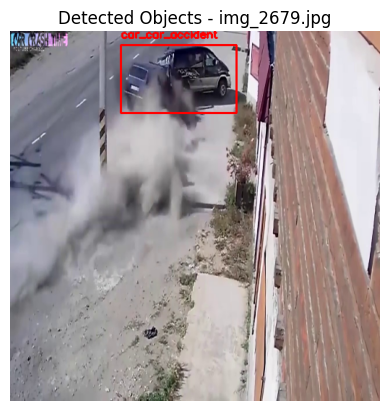

1/1 [==============================] - 0s 28ms/step


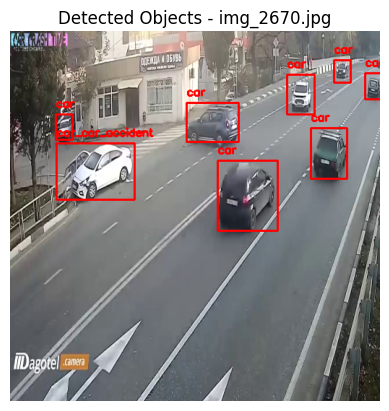

1/1 [==============================] - 0s 28ms/step


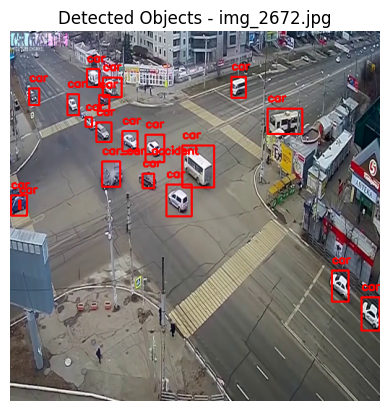

1/1 [==============================] - 0s 29ms/step


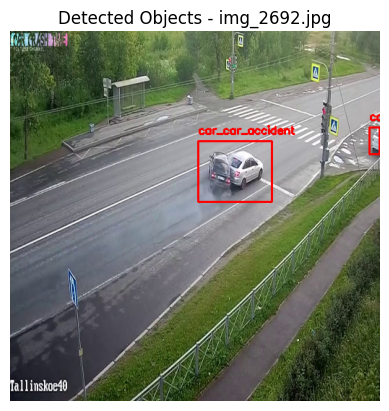

1/1 [==============================] - 0s 29ms/step


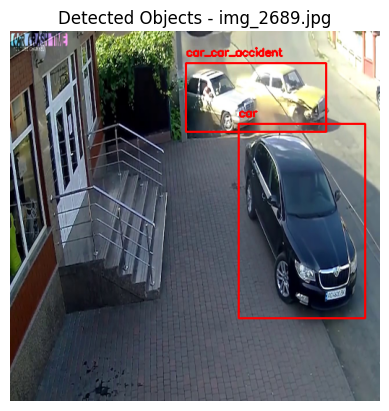

1/1 [==============================] - 0s 28ms/step


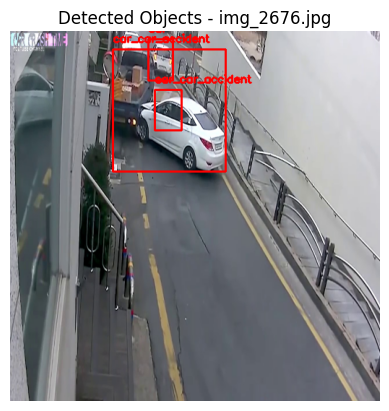

1/1 [==============================] - 0s 27ms/step


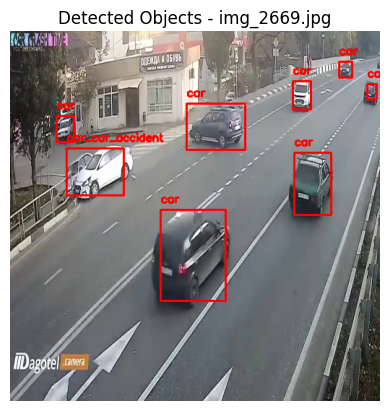

1/1 [==============================] - 0s 31ms/step


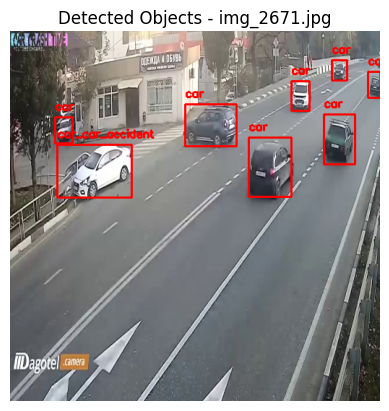

1/1 [==============================] - 0s 31ms/step


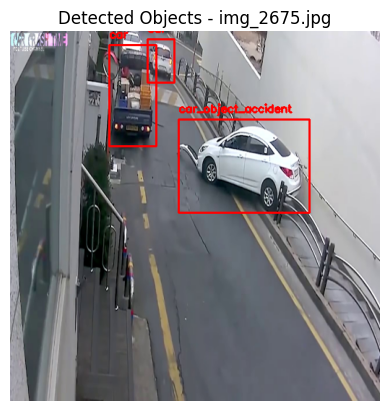

1/1 [==============================] - 0s 28ms/step


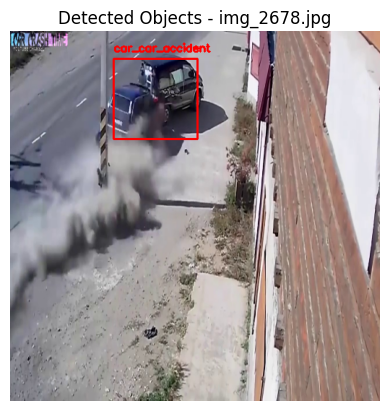

1/1 [==============================] - 0s 29ms/step


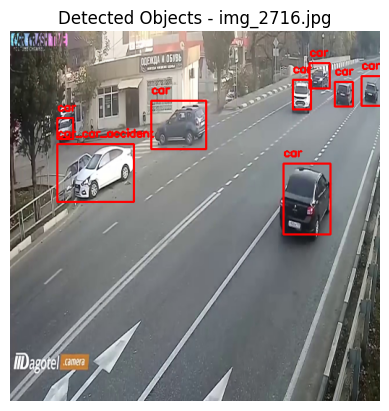

1/1 [==============================] - 0s 30ms/step


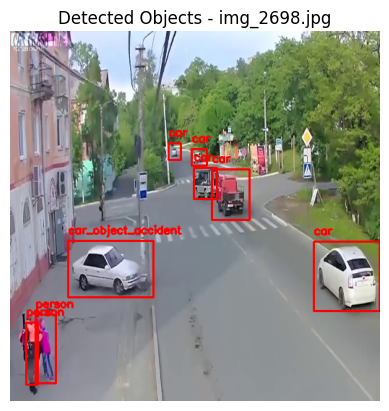

1/1 [==============================] - 0s 27ms/step


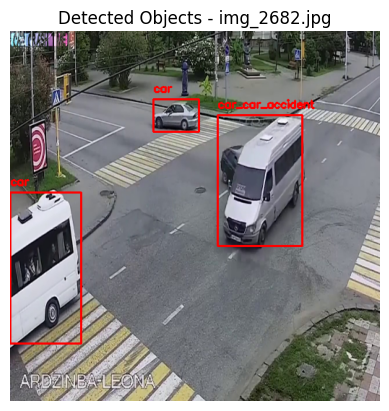

1/1 [==============================] - 0s 26ms/step


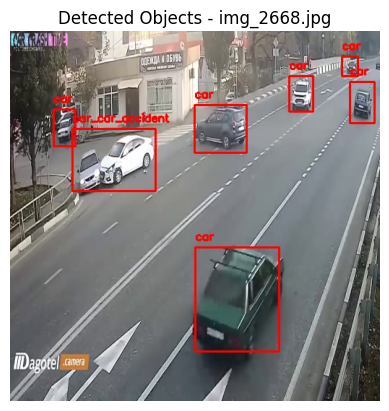

1/1 [==============================] - 0s 27ms/step


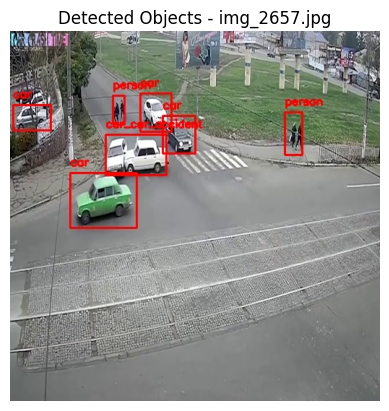

1/1 [==============================] - 0s 28ms/step


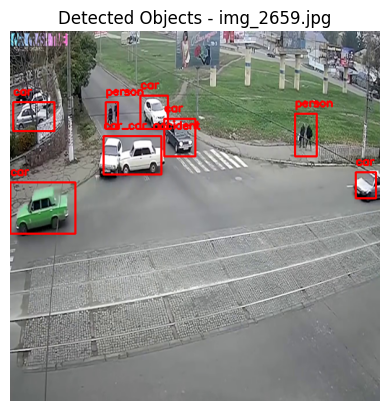

1/1 [==============================] - 0s 29ms/step


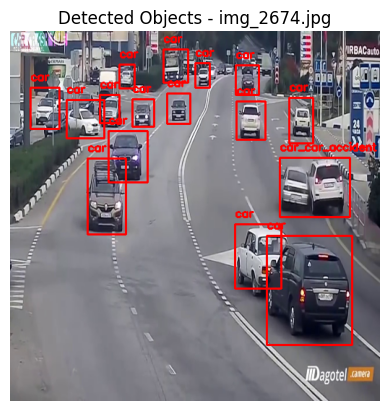

1/1 [==============================] - 0s 27ms/step


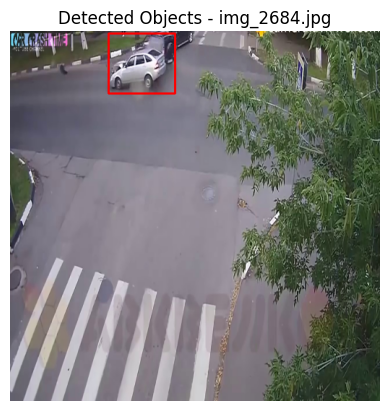

1/1 [==============================] - 0s 27ms/step


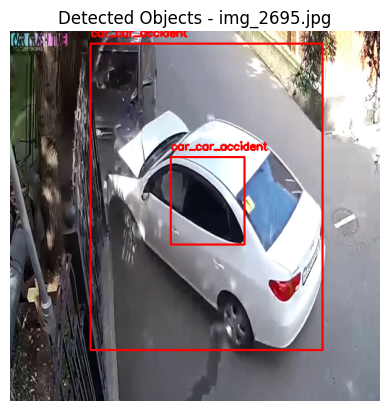

1/1 [==============================] - 0s 28ms/step


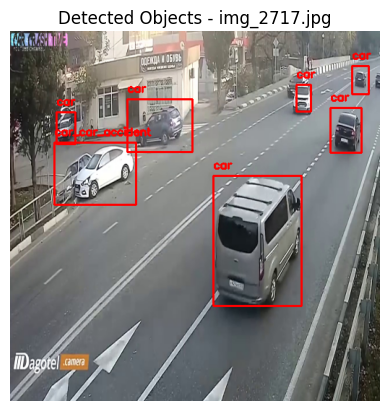

1/1 [==============================] - 0s 27ms/step


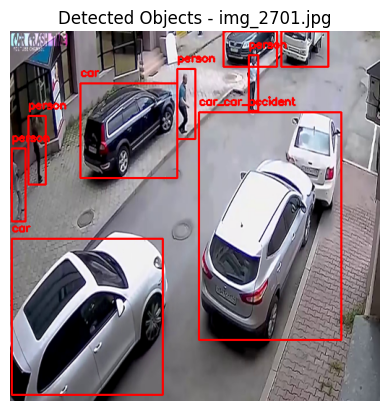

1/1 [==============================] - 0s 28ms/step


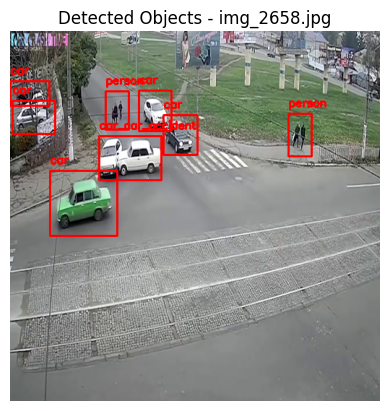

1/1 [==============================] - 0s 29ms/step


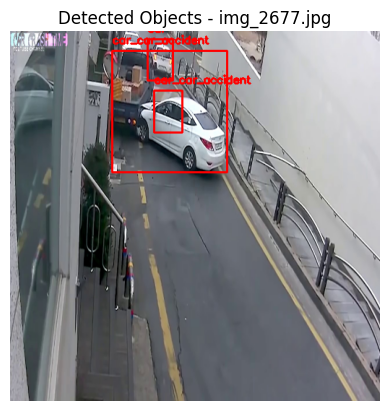


Total accident images processed: 30
Accident detected in 26 accident images
Accident Detection Accuracy: 86.66666666666667 %



In [38]:
total_accident_images, accident_detected_count = model_test("/kaggle/input/cctv-accident-image-dataset/data/test/images/Accident/")
print("\nTotal accident images processed:", total_accident_images)
print("Accident detected in", accident_detected_count, "accident images")

accident_accuracy = (accident_detected_count / total_accident_images) * 100 if total_accident_images != 0 else 0
print("Accident Detection Accuracy:", accident_accuracy, "%\n")

1/1 [==============================] - 0s 28ms/step


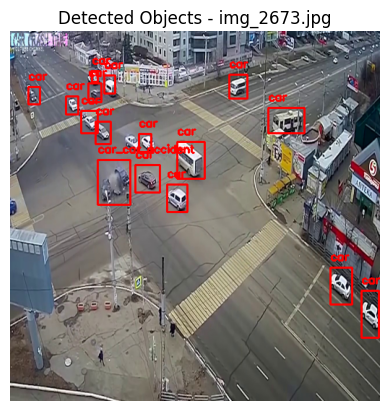

1/1 [==============================] - 0s 27ms/step


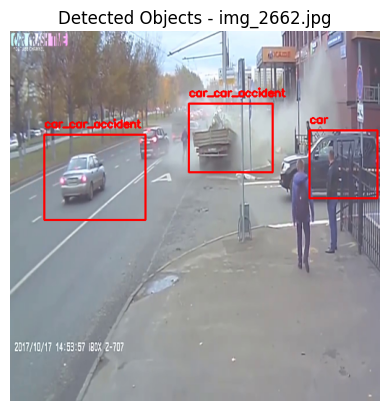

1/1 [==============================] - 0s 32ms/step


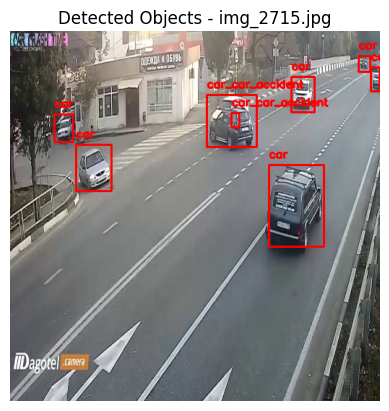

1/1 [==============================] - 0s 30ms/step


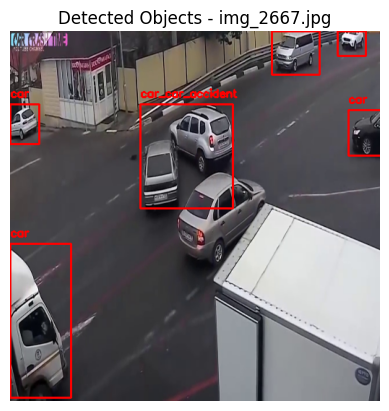

1/1 [==============================] - 0s 26ms/step


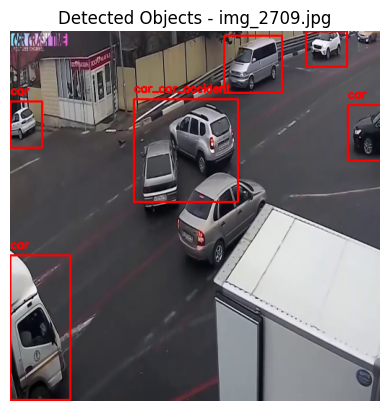

1/1 [==============================] - 0s 27ms/step


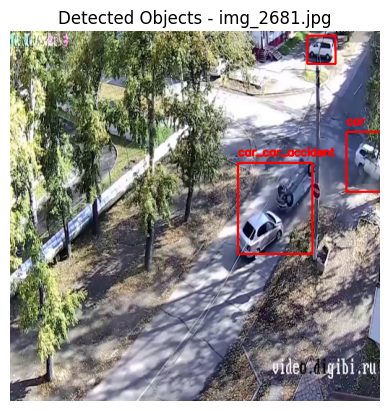

1/1 [==============================] - 0s 28ms/step

Total non-accident images processed: 70
Non-accident detected in 62 non-accident images
Non-Accident Detection Accuracy: 88.57142857142857 %


In [39]:
total_non_accident_images, wrong_accident_detected_count = model_test("/kaggle/input/cctv-accident-image-dataset/data/test/images/Non Accident")
non_accident_detected_count = total_non_accident_images - wrong_accident_detected_count
# Calculate accuracy for non-accident images
non_accident_accuracy = (non_accident_detected_count / total_non_accident_images) * 100 if total_non_accident_images != 0 else 0

print("\nTotal non-accident images processed:", total_non_accident_images)
print("Non-accident detected in", non_accident_detected_count, "non-accident images")
print("Non-Accident Detection Accuracy:", non_accident_accuracy, "%")
# The following are mis-predictions where accident hasn't happened but model is predicting

In [40]:
# Calculate total accuracy
total_images = total_accident_images + total_non_accident_images
total_correct_predictions = accident_detected_count + non_accident_detected_count

total_accuracy = (total_correct_predictions / total_images) * 100 if total_images != 0 else 0

print("\nTotal images processed:", total_images)
print("Total correct predictions:", total_correct_predictions)
print("Overall Accuracy:", total_accuracy, "%")


Total images processed: 100
Total correct predictions: 88
Overall Accuracy: 88.0 %


# **Thank you!**